# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 2: Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">


In [4]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Restart the kernel and run the whole notebook again before you submit. 
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed.

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

C:\Users\sugar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## <div class="theme">  <b>Predicting Taxi Pickups in NYC</b> </div>

In this homework, we will explore k-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

### <div class="exercise"> <b> Question 1  [20 pts]</b> </div>

**1.1**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 42 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is dependent on the time of the day.  Be sure to title your plot.

**1.3**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly surmise why this may be the case.  This will not be graded harshly, we just want you to think and communicate about the cause.


### Answers

**1.1 Use pandas to load the dataset from the csv file ...**

In [5]:
# read the file
nyc_taxi = pd.read_csv('nyc_taxi.csv')
display(nyc_taxi.head())
nyc_taxi.describe()
# your code here


,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


,TimeMin,PickupCount
count,1250.00000,1250.000000
mean,702.46800,33.230400
std,405.49001,19.136391
min,4.00000,1.000000
25%,361.50000,17.000000
50%,688.50000,33.000000
75%,1046.75000,46.000000
max,1438.00000,116.000000


In [6]:
# split the data
# your code here
train_data, test_data = train_test_split(nyc_taxi, test_size=0.2, random_state=42)

**1.2 Generate a scatter plot of the training data points**


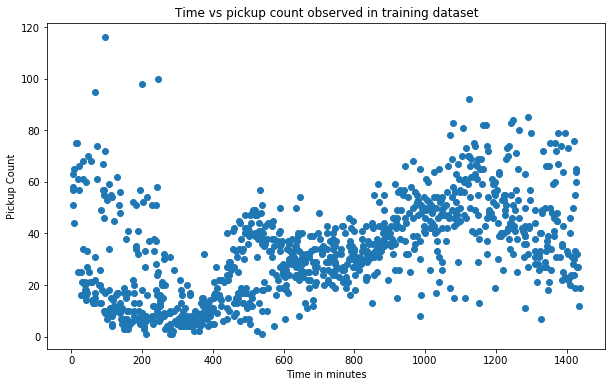

In [7]:
# Your code here
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(train_data['TimeMin'], train_data['PickupCount'],'o')
ax.set_xlabel('Time in minutes')
ax.set_ylabel('Pickup Count')
ax.set_title('Time vs pickup count observed in training dataset')

**1.3 In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**

*your answer here*  
*Pickup count pattern is like a sin curve, as the count trends to be higher from about minute 1100 (around 6 PM) and decrease slowly to the lowest value at about minute 300 (around 5 AM next morning). Then, the count climbs up slowly until reaching the highest value at around 6 PM again. The pattern could be due to people's activity density. People normally start a day after 5 AM, and have various activities (commute to work, go to school, hanging out, etc.). And people normally end their routine work at around 6PM, which explains the peak value. People may hangout late at night (dine out, visit a friend, etc.) and go back home aroung midnight, which explains the low value after midnight and before the next morning.*



**1.4 You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes...**

*your answer here*  
*Minute 500-550 is roughly 8-9 AM, which is the main time period when people leave home and go to work/school on weekdays. Therefore, on weekdays more pickups are expected while at weekends less pickups are expected (because people may choose to stay at home and sleep in). The stratification on weekdays and weekends results in the "hole" observed in the plot.*



<hr>

### <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen k-Nearest Neighbors (k-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run k-NN Regression. 


**2.1**. Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4**. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).

### Answers

**2.1 Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary...** 

In [8]:
# your code here
k_set = {1,10,75,250,500,750,1000}
KNNModels={}
for each in k_set:
    neighbors = KNeighborsRegressor(n_neighbors=each)
    neighbors.fit(train_data[['TimeMin']],train_data['PickupCount'])
    KNNModels[each] = neighbors

**2.2  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set...**

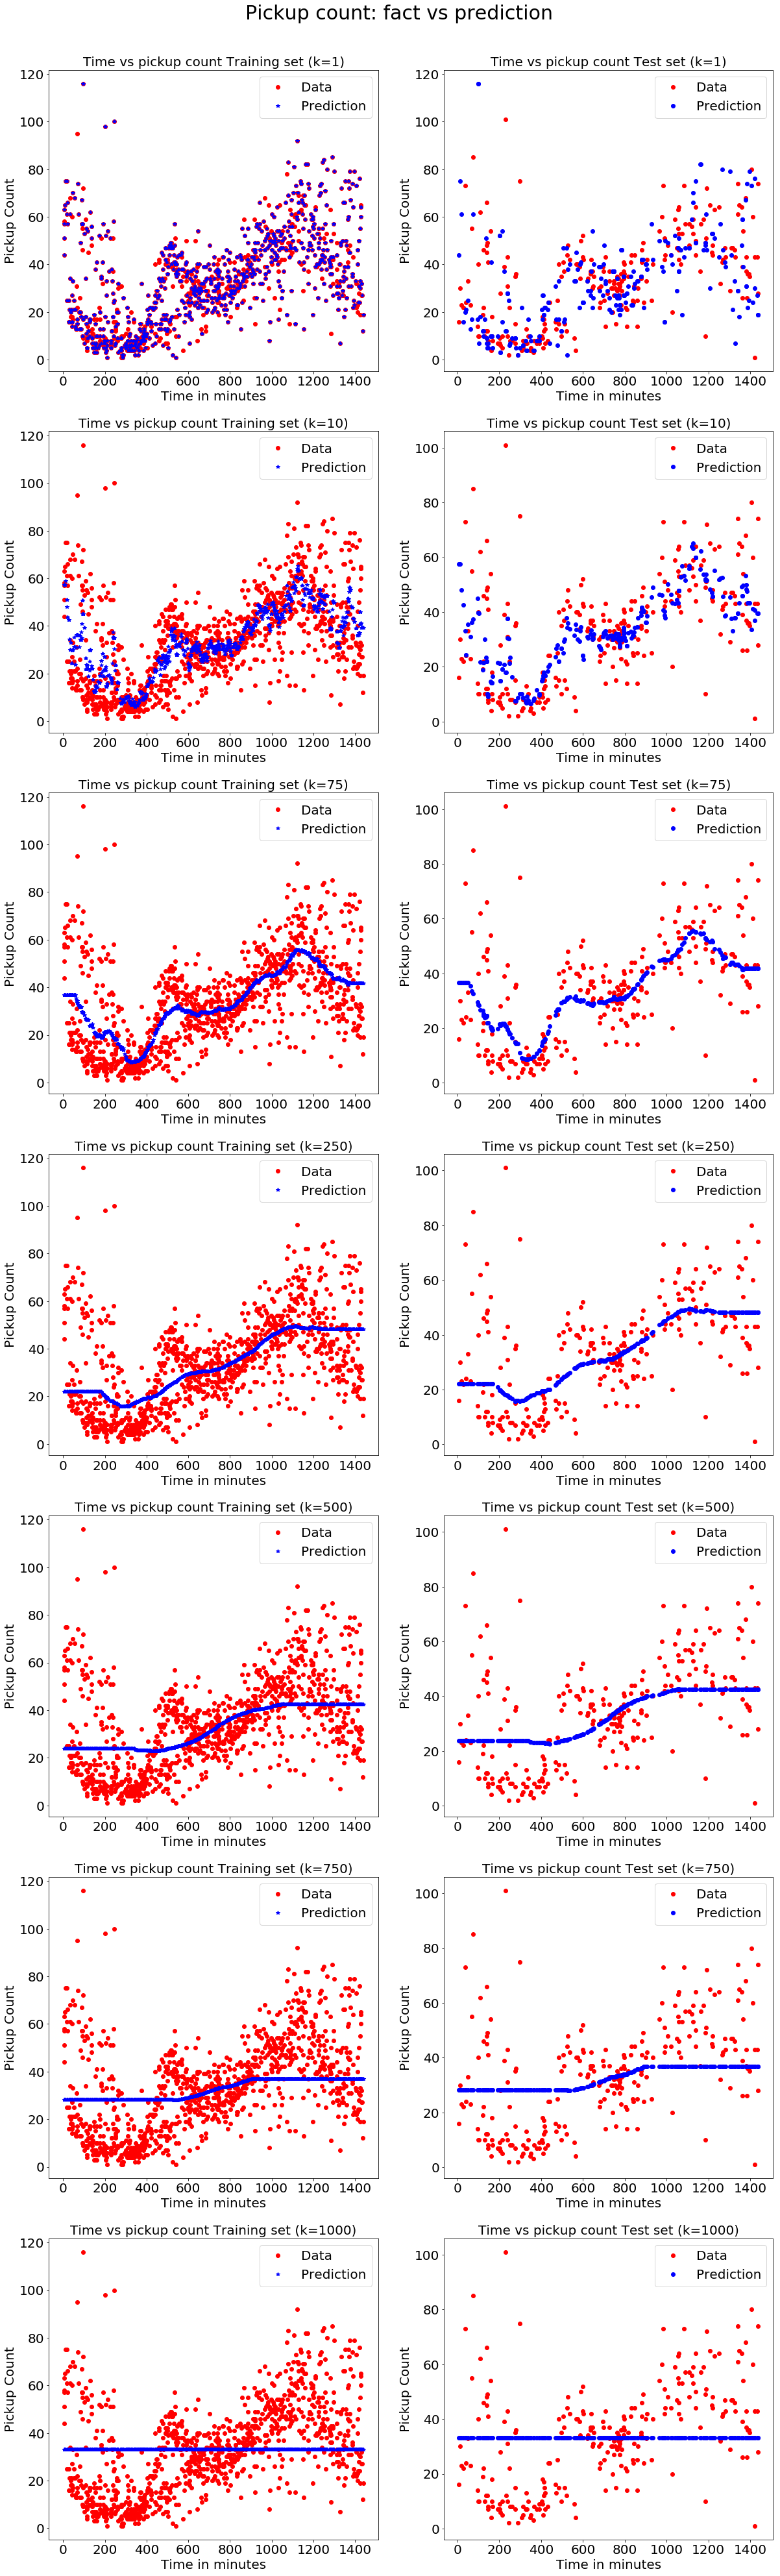

In [9]:
# your code here 
fig, axes = plt.subplots(7,2,figsize=(20,70))
fig.suptitle('Pickup count: fact vs prediction',fontsize=30,y=.90)
k_list = list(k_set)
k_list.sort()

for i,ax in enumerate(axes):
    k = k_list[i]
    ax[0].plot(train_data['TimeMin'], train_data['PickupCount'],'or',label='Data')
    ax[0].plot(train_data['TimeMin'], KNNModels[k].predict(train_data[['TimeMin']]),'*b',label='Prediction')
    ax[0].set_xlabel('Time in minutes',fontsize=20)
    ax[0].set_ylabel('Pickup Count',fontsize=20)
    ax[0].legend(fontsize=20)
    ax[0].set_title('Time vs pickup count Training set (k={})'.format(k),fontsize=20)
    ax[0].tick_params(labelsize = 20)
    
    ax[1].plot(test_data['TimeMin'], test_data['PickupCount'],'or',label='Data')
    ax[1].plot(test_data['TimeMin'], KNNModels[k].predict(test_data[['TimeMin']]),'ob',label='Prediction')
    ax[1].set_xlabel('Time in minutes',fontsize=20)
    ax[1].set_ylabel('Pickup Count',fontsize=20)
    ax[1].legend(fontsize=20)
    ax[1].set_title('Time vs pickup count Test set (k={})'.format(k),fontsize=20)
    ax[1].tick_params(labelsize = 20)


**2.3 Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**


In [10]:
# your code here
df_dict = {}
df_dict['k']=[]
df_dict['Train R square']=[]
df_dict['Test R square']=[]
for k in k_list:
    df_dict['k'].append(k)
    df_dict['Train R square'].append(r2_score(train_data['PickupCount'], KNNModels[k].predict(train_data[['TimeMin']])))
    df_dict['Test R square'].append(r2_score(test_data['PickupCount'], KNNModels[k].predict(test_data[['TimeMin']])))
   

Rsquare=pd.DataFrame(df_dict,columns = ['k','Train R square','Test R square'])
Rsquare 


,k,Train R square,Test R square
0,1,0.712336,-0.418932
1,10,0.509825,0.272068
2,75,0.445392,0.390310
3,250,0.355314,0.340341
4,500,0.290327,0.270321
5,750,0.179434,0.164909
6,1000,0.000000,-0.000384


**2.4 Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

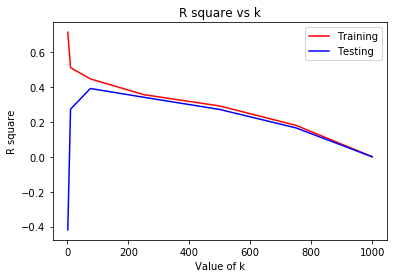

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot((Rsquare['k']),Rsquare['Train R square'],'r',label='Training')
ax.plot((Rsquare['k']),Rsquare['Test R square'],'b',label='Testing')
ax.set_xlabel('Value of k')
ax.set_ylabel('R square')
ax.set_title('R square vs k')
ax.legend()

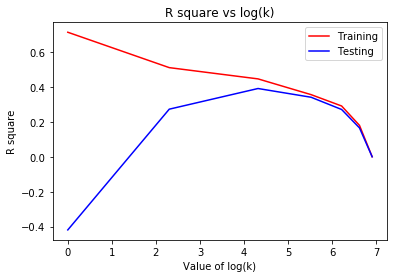

In [12]:
# Since k is not changing in linear scale, 
# plot R square as function of log(k) may better show 
# the difference between training and testing
fig, ax = plt.subplots(1,1)
ax.plot(np.log(Rsquare['k']),Rsquare['Train R square'],'r',label='Training')
ax.plot(np.log(Rsquare['k']),Rsquare['Test R square'],'b',label='Testing')
ax.set_xlabel('Value of log(k)')
ax.set_ylabel('R square')
ax.set_title('R square vs log(k)')
ax.legend()

**2.5 Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

*your answer here*  
*It is actually using the mean of resopnse in the whole training dataset as a uniform prediction of the response.*

2. What does an $R^2$ score of $0$ mean?  

*your answer here*  
*It means that the model being assessed cannot give any better prediction than just taking the mean of the whole dataset as a prediction, and "best" means the model gives the least sum of residuals square.*


3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

*your answer here*  
*Negative $R^2$ means the prediction of the model is even worse than using the mean of resopnse in the whole training dataset as a prediction. When k = 1 and 1000, negative $R^2$s are observed.*

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

*your answer here*  
*Yes. The $R^2$ of training dataset monotonically decreases as k goes up, while the $R^2$ of testing dataset increases first and decreases after reaching a maximum, as k goes up.*

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

*your answer here*  
*Based on the plots and calculation above, the best k is the one with the biggest testing $R^2$ $(k=75)$. When $k=75$, the training set $R^2$ value (0.445392) is slightly bigger than the testing $R^2$ value (0.390310).*

6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).** ****

*your answer here*  
*The prediction  for $k>75$ are too flat to reflect the fluctuation of response, while the prediction for $k<75$ are too sensitive to noise.*

<hr>

### <div class="exercise"> <b> Question 3 [25 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4**. Report the estimates for the slope and intercept for the fitted linear model.  

**3.5**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers

**3.1 Again choose `TimeMin` as your predictor and `PickupCount` as your response variable...**

In [13]:
# your code here
x_train, y_train = train_data['TimeMin'], train_data['PickupCount']
x_test, y_test = test_data['TimeMin'], test_data['PickupCount']
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)
OLSModel = sm.OLS(y_train,x_train_ca).fit()

**3.2 Create a plot just like you did in 2.2 (but with fewer subplots)...** 

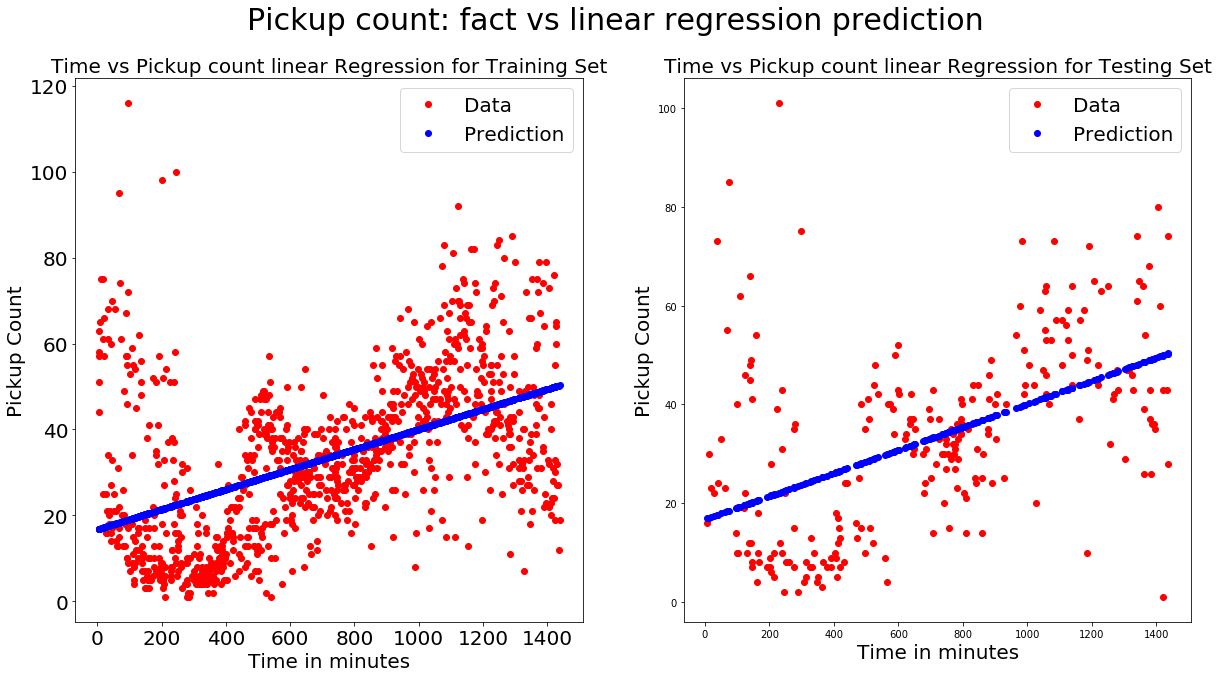

In [14]:
# your code here
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(x_train, y_train, 'or',label='Data')
axes[0].plot(x_train, OLSModel.predict(x_train_ca),'ob',label='Prediction')
axes[0].set_title('Time vs Pickup count linear Regression for Training Set',fontsize=20)
axes[0].set_xlabel('Time in minutes',fontsize=20)
axes[0].set_ylabel('Pickup Count',fontsize=20)
axes[0].legend(fontsize=20)
axes[0].tick_params(labelsize = 20)

axes[1].plot(x_test, y_test, 'or',label='Data')
axes[1].plot(x_test, OLSModel.predict(x_test_ca),'ob',label='Prediction')
axes[1].set_title('Time vs Pickup count linear Regression for Testing Set',fontsize=20)
axes[1].set_xlabel('Time in minutes',fontsize=20)
axes[1].set_ylabel('Pickup Count',fontsize=20)
axes[1].legend(fontsize=20)
axes[0].tick_params(labelsize = 20)
fig.suptitle('Pickup count: fact vs linear regression prediction',fontsize=30)

**3.3 Report the $R^2$ score for the fitted model on both the training and test sets.**


In [15]:
# your code here
print('R^2 Score for Linear Regression (Training):',r2_score(y_train, OLSModel.predict(x_train_ca)))
print('R^2 Score for Linear Regression (Testing):',r2_score(y_test, OLSModel.predict(x_test_ca)))

R^2 Score for Linear Regression (Training): 0.243026035319
R^2 Score for Linear Regression (Testing): 0.240661535616


**3.4 Report the estimates for the slope and intercept for the fitted linear model.**

In [16]:
# your code here
print('Estimate for slope: ', OLSModel.params[1])
print('Estimate for intercept: ', OLSModel.params[0])

Estimate for slope:  0.0233351756924
Estimate for intercept:  16.7506014274


**3.5 Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 


In [17]:
# your code here
thresh = 0.05 
intervals = OLSModel.conf_int(alpha=thresh)
intervals.columns = ['2.5%','97.5%']
intervals.index = ['intercept','slope']
intervals

,2.5%,97.5%
intercept,14.675141,18.826062
slope,0.020777,0.025893


**3.6 Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

*your answer here*  
*The $R^2$ in testing dataset is 0.240661535616, smaller than that of k-NN regression with k = 75 (0.445392). It is not surprising because the pattern of time and pickup count is not likely to be linear, and linear regression model is bound to give prediction with higher error.*

2. What does the sign of the slope of the fitted linear model convey about the data?  

*your answer here*  
*The slope is positive, which means that as time in minute goes up, pickup count trends to increase as well.*


3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 


*your answer here*  
*For every split of thr original dataset, we can fit a separate model and calculate the 95% CI. The 95% CIs mean that given infinite times of split, the chance of the true value falls in the CI is 95%. Thus we are 95% sure that the true intercept in the linear model is between 14.675141	and 18.826062, and the true slope in the linear model is between 0.020777 and 0.025893. Since the slope 95% CI doesn't include 0, we are convinced that the number of taxi pickups has a significant linear relationship with time of day. The chance of the number of taxi pickups not having a significant linear relationship with time of day, given this CI, is less than 2.5%.*


4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  


*your answer here*  
*If we use linear regression, we are assuming that the Y (response variable) is normally distributed, as well as the slope. Normal distribution is symmetric, so 99% CI has the same midpoint as 95% CI. Since we want higher confidence to make sure the true value is included in 99% CI, we should expect it to be wider.*

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

*your answer here*  
*Response at $x\approx0$ and $x\approx1440$ should be almost the same, bacause the time of a day is cycling, and 11:59 PM is not significantly different from 00:01 AM next day. Such assumption means linear model is not suitbale in this case, since linear model is monotinic.*

<hr>

## <div class="theme"> Outliers </div>

You may recall from lectures that OLS Linear Regression can be susceptible to outliers in the data.  We're going to look at a dataset that includes some outliers and get a sense for how that affects modeling data with Linear Regression.  **Note, this is an open-ended question, there is not one correct solution (or even one correct definition of an outlier).**


### <div class="exercise"><b> Question 4 [30 pts] </b></div>




**4.1**. We've provided you with two files `outliers_train.csv` and `outliers_test.csv` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of potential outliers in the data?

**4.2**. Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.

**4.3**. You're given the knowledge ahead of time that there are 3 outliers in the training set data.  The test set data doesn't have any outliers.  You want to remove the 3 outliers in order to get the optimal intercept and slope.  In the case that you're sure of the existence and number (3) of outliers ahead of time, one potential brute force method to outlier detection might be to find the best Linear Regression model on all possible subsets of the training set data with 3 points removed.  Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?

**4.4**  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data. Place your algorithm in the function `find_outliers_simple`.  It should take the parameters `dataset_x`, `dataset_y`, and `num_outliers` representing your features, response variable values (make sure your response variable is stored as a numpy column vector), and the number of outliers to remove.  Your algorithm should select the `num_outliers` most extreme residuals from the linear regression model to predict, `dataset_y` from `dataset_x`.  The return value should be a list `outlier_indices` representing the indices of the `num_outliers` outliers in the original datasets you passed in.  Apply your function to the training data in order to identify 3 outliers.  Use `statsmodels` to create a Linear Regression model on the remaining training set data (with the 3 outliers removed), and store your model in the variable `OutlierFreeSimpleModel`.

**4.5** Create a figure with two subplots: the first is a scatterplot where the color of the points denotes the outliers from the non-outliers in the training set, and include two regression lines on this scatterplot: one fitted with the outliers included and one fitted with the outlier removed (all on the training set).  The second plot should include a scatterplot of points from the test set with the same two regression lines fitted on the training set: with and without outliers.  Visually which model fits the test set data more closely?

**4.6**. Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?

**4.7**. One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers.  In general you can't expect to know ahead of time the number of outliers in your dataset.  Propose how you would alter and/or use the algorithm you constructed in 4.4 to create a more general heuristic (i.e. one which doesn't presuppose the number of outliers) for finding outliers in your dataset.  

**Hints**:
   1. Should outliers be removed one at a time or in batches?
   2. What metric would you use and how would you use it to determine how many outliers to consider removing?

### Answers
**4.1  We've provided you with two files `outliers_train.csv` and `outliers_test.csv` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of outliers in the data?** 

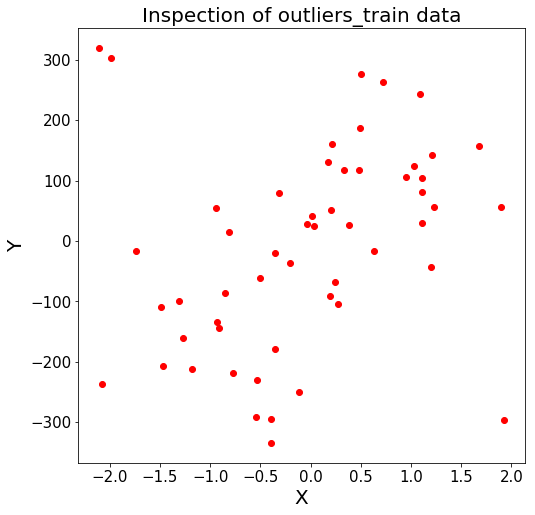

In [90]:
# read the data
# your code here
outliers_train = pd.read_csv('outliers_train.csv')
outliers_test = pd.read_csv('outliers_test.csv')
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(outliers_train['X'],outliers_train['Y'],'or')
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
ax.set_title('Inspection of outliers_train data',fontsize=20)
ax.tick_params(labelsize = 15)

*your answer here*  
*Two outliers in topleft, one outlier in bottomright.*
  


**4.2 Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.**



In [91]:
# your code here
x_train_outliers, y_train_outliers = outliers_train['X'], outliers_train['Y']
x_train_outliers_ca = sm.add_constant(x_train_outliers)
x_test_outliers, y_test_outliers = outliers_test['X'], outliers_test['Y']
x_test_outliers_ca = sm.add_constant(x_test_outliers)
OutlierOLSModel=sm.OLS(y_train_outliers, x_train_outliers_ca).fit()

**4.3 You're given the knowledge ahead of time that there are 3 outliers...Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?**
  

*your answer here*  
*Choose 50 from 53 (total number of observation in outliers_train) is $\binom{53}{50} = \binom{53}{3}= \frac{53\cdot 52\cdot 51}{3\cdot 2\cdot 1}=23426$*


**4.4  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data...**

In [65]:
def find_outliers_simple(dataset_x, dataset_y, num_outliers):
    # your code here
    model = sm.OLS(dataset_y,dataset_x).fit()
    predict_y = model.predict(dataset_x)
    residuals_square=(predict_y-dataset_y)**2
    outlier_indices = np.argsort(-residuals_square)[0:num_outliers]    
    return list(outlier_indices)

In [79]:
# get outliers and calculate outlier model
# your code here
outlier_indices = find_outliers_simple(x_train_outliers_ca, y_train_outliers, 3)
print(outlier_indices)
OutlierFreeSimpleModel = sm.OLS(y_train_outliers.drop(outlier_indices), x_train_outliers_ca.drop(outlier_indices)).fit()

[50, 51, 52]


**4.5 Create a figure with two subplots: the first is a scatterplot where the color of the points...**


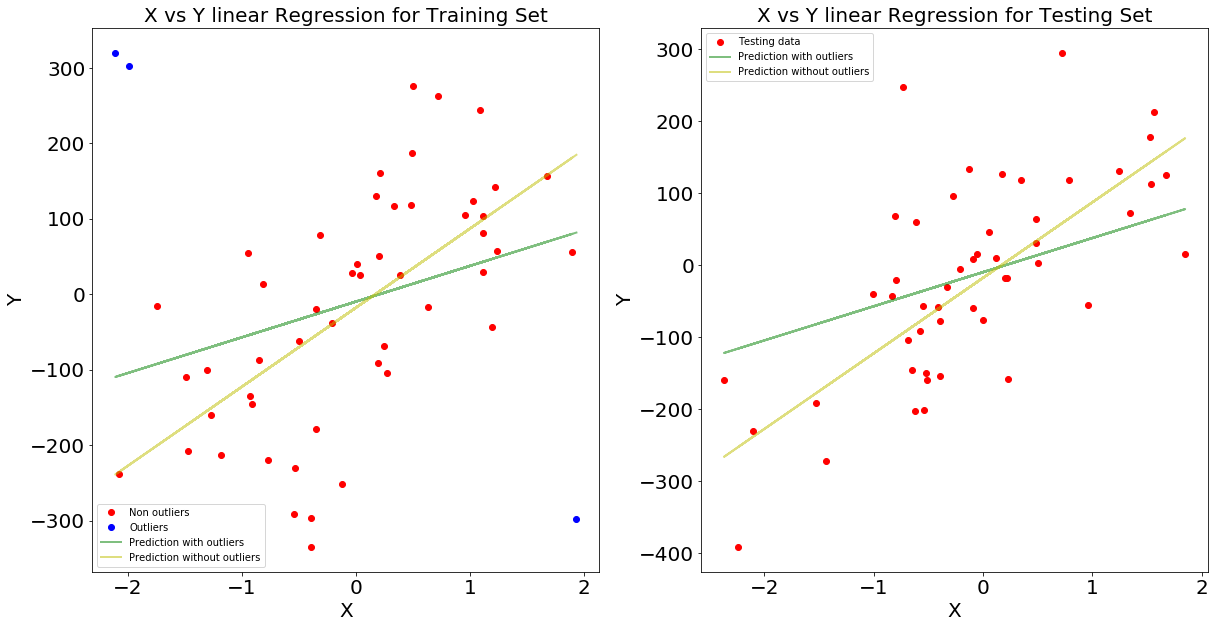

In [97]:
# plot 
# your code here
outlier_indices = find_outliers_simple(x_train_outliers_ca, y_train_outliers, 3)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(x_train_outliers.drop(outlier_indices), y_train_outliers.drop(outlier_indices), 'or',label='Non outliers')
axes[0].plot(x_train_outliers.loc[outlier_indices], y_train_outliers.loc[outlier_indices],'ob',label='Outliers')
axes[0].plot(x_train_outliers, OutlierOLSModel.predict(x_train_outliers_ca),'-g',label='Prediction with outliers',alpha=0.5,linewidth=2)
axes[0].plot(x_train_outliers, OutlierFreeSimpleModel.predict(x_train_outliers_ca),'-y',label='Prediction without outliers',alpha=0.5,linewidth=2)
axes[0].legend()
axes[0].set_title('X vs Y linear Regression for Training Set',fontsize=20)
axes[0].set_xlabel('X',fontsize=20)
axes[0].set_ylabel('Y',fontsize=20)
axes[0].tick_params(labelsize = 20)

axes[1].plot(x_test_outliers, y_test_outliers, 'or',label='Testing data')
axes[1].plot(x_test_outliers, OutlierOLSModel.predict(x_test_outliers_ca),'-g',label='Prediction with outliers',alpha=0.5,linewidth=2)
axes[1].plot(x_test_outliers, OutlierFreeSimpleModel.predict(x_test_outliers_ca),'-y',label='Prediction without outliers',alpha=0.5,linewidth=2)
axes[1].legend()
axes[1].set_title('X vs Y linear Regression for Testing Set',fontsize=20)
axes[1].set_xlabel('X',fontsize=20)
axes[1].set_ylabel('Y',fontsize=20)
axes[1].tick_params(labelsize = 20)

*your answer here*  
*The model without outliers fits the test data more closely.*


**4.6 Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?**


In [100]:
# your code here
print('R^2 Score for Linear Regression (Testing, with outliers):',r2_score(y_test_outliers, OutlierOLSModel.predict(x_test_outliers_ca)))
print('R^2 Score for Linear Regression (Testing, without outliers):',r2_score(y_test_outliers, OutlierFreeSimpleModel.predict(x_test_outliers_ca)))
print('The model without outliers produces a better R^2 Score.')

R^2 Score for Linear Regression (Testing, with outliers): 0.340856560434
R^2 Score for Linear Regression (Testing, without outliers): 0.452956687017
The model without outliers produces a better R^2 Score.


**4.7 One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers...**

*your answer here*  
*We can calculate the Cook's distance of every data point and select the points with Cook's distance larger than a certain threshold. A rule of thumb is $\frac {4}{n-2}$, where n is the number of observations. Then remove all these points in batch.*
